In [1]:
!pip install pandas
!pip install xlrd
!pip install openpyxl
!pip install imblearn

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [2]:
import pandas as pd
import numpy as np

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

import sklearn
from sklearn import model_selection, preprocessing, linear_model, naive_bayes
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE 

### Defining helping functions

In [3]:
#preprocess data
def clean_text_column(df_col):
    ''' Cleaning text in given dataframe column'''

    #make text lower case
    df_col = df_col.astype(str)
    df_col = df_col.str.lower() 

    #removing url's, special characters except punctuations, multiple whitespaces, numbers
    regex_list = [r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', r'[^\.\w\s\ ]', r'\s+', r'[0-9]'] 
    #r'type', r'diabetes'
    replace_list = [' ', ' ', ' ', '', '']

    for i in range(len(regex_list)):
        df_col = df_col.str.replace(regex_list[i], replace_list[i]) 

    #Fill empty cells with nan values
    df_col.replace('', np.nan, inplace=True)

    #remove stop-words
    stop_words = stopwords.words('english')
    df_col = df_col.apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)])) #removing stopwords from news contents.

    # remove small words
    df_col = df_col.apply(lambda x: ' '.join([word for word in x.split() if len(word) > 3]))
    df_col = df_col.apply(lambda x: ' '.join([word for word in x.split() if len(word) > 3]))

    #lemmatization
    lemmatizer = WordNetLemmatizer()
    df_col = df_col.apply(lambda x: " ".join([lemmatizer.lemmatize(word) for word in x.split()]))

    return df_col

def get_important_features(grid_object, n=20):
    ''' retreiving most and least informative features from gridsearch object. 
    Adjustment for gridsearch and pipeline object added to existing solution.
    Credit: https://stackoverflow.com/questions/29867367/sklearn-multinomial-nb-most-informative-features'''
    
    feature_names = grid_object.best_estimator_.named_steps['vect'].get_feature_names()
    coefs_with_fns = sorted(zip(grid_object.best_estimator_.named_steps['clf'].coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s" % (coef_2, fn_2))
            
    return None

### Upload and clean data

Data sets are denoted accordingly: patient journey 'pj' and emotions 'em'.

In [4]:
df_pj = pd.read_excel('Diabetes-classification.xlsx', sheet_name = 0, index_col=0, engine='openpyxl') 
#display(df_pj)
df_em = pd.read_excel('Diabetes-classification.xlsx', sheet_name = 1, index_col=0, engine='openpyxl') 
#display(df_em)

<AxesSubplot:ylabel='Label'>

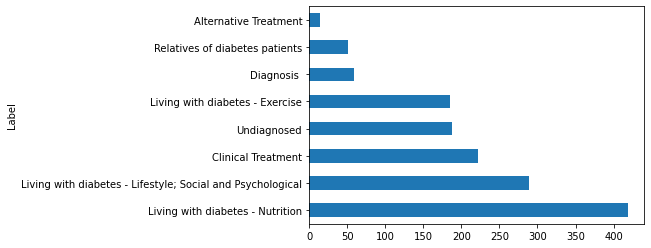

In [5]:
df_pj.value_counts('Label').plot(kind='barh')

<AxesSubplot:ylabel='Label'>

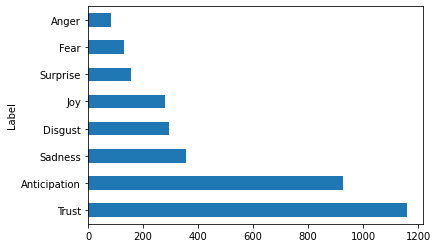

In [6]:
df_em.value_counts('Label').plot(kind='barh')

In [7]:
#cleaning data
X_pj = clean_text_column(df_pj.discussion_text.copy()) 
X_em = clean_text_column(df_em.discussion_text.copy()) 

#Converting labels to integers between 0 and n-1
encoder_pj, encoder_em = preprocessing.LabelEncoder(), preprocessing.LabelEncoder()
labels_pj, labels_em = encoder_pj.fit_transform(df_pj.Label.copy()), encoder_em.fit_transform(df_em.Label.copy())
label_mapping_pj = dict(zip(encoder_pj.classes_, encoder_pj.transform(encoder_pj.classes_)))
label_mapping_em = dict(zip(encoder_em.classes_, encoder_em.transform(encoder_em.classes_)))

#Splitting data
X_pj, X_pj_test, y_pj, y_pj_test = train_test_split(X_pj, labels_pj, test_size=0.2, random_state=1)
X_em, X_em_test, y_em, y_em_test = train_test_split(X_em, labels_em, test_size=0.2, random_state=1)

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: The default value of regex will change from True to False in a future version.
  from ipykernel import kernelapp as app


In [8]:
#Checking shapes of data splits
print(X_pj.shape, X_pj_test.shape, y_pj.shape, y_pj_test.shape)
print(X_em.shape, X_em_test.shape, y_em.shape, y_em_test.shape)

(1140,) (286,) (1140,) (286,)
(2708,) (678,) (2708,) (678,)


## Training Models
For each model, a pipeline and grid search parameters are defined. GridSearchCV() is used to measure validation score on combinations of model parameters. Combinations are made from using the detined parameters on the defined pipeline. The left handside of the defined parameters refer to the name of the method in the pipeline followed by '__' and the name of the parameter related to that function it holds values for.

### Training Multinomial Bayes Models


In [9]:
nb_clf = Pipeline([('vect', CountVectorizer()),
                ('sampling', SMOTE(random_state=42)),
                ('clf', MultinomialNB())])

parameters = {'vect__ngram_range': [(1, 1), (1, 2)],
              'clf__fit_prior': (True, False),
              'clf__alpha': (0.5, 1.0)}

#Patient journey model
nb_pj = GridSearchCV(nb_clf, parameters, n_jobs=-1) #performing gridsearch
nb_pj.fit(X_pj, y_pj)

print("best mean cross-validation score: {:.3f}".format(nb_pj.best_score_))
print("best parameters:", nb_pj.best_params_) 

print('NB classifier of patient journey - report:\n\n',
    classification_report(y_pj_test, nb_pj.predict(X_pj_test), digits=4, 
    target_names=label_mapping_pj))

best mean cross-validation score: 0.476
best parameters: {'clf__alpha': 1.0, 'clf__fit_prior': True, 'vect__ngram_range': (1, 1)}
NB classifier of patient journey - report:

                                                             precision    recall  f1-score   support

                                     Alternative Treatment     0.0000    0.0000    0.0000         3
                                        Clinical Treatment     0.4048    0.4857    0.4416        35
                                                Diagnosis      0.2500    0.0833    0.1250        12
                           Living with diabetes - Exercise     0.5455    0.3913    0.4557        46
Living with diabetes - Lifestyle; Social and Psychological     0.3966    0.3898    0.3932        59
                          Living with diabetes - Nutrition     0.4957    0.7532    0.5979        77
                            Relatives of diabetes patients     1.0000    0.0714    0.1333        14
                        

In [10]:
nb_clf2 = Pipeline([('vect', CountVectorizer()),
                    ('tfidf', TfidfTransformer()),
                    ('clf', MultinomialNB())])

parameters2 = {#'vect__ngram_range': [(1, 1), (1, 2)],
            'clf__fit_prior': (True, False),
            'clf__alpha': (0.5, 1.0)}

#Emotions model
nb_em = GridSearchCV(nb_clf2, parameters2, n_jobs=-1)
nb_em.fit(X_em, y_em)

print("best mean cross-validation score: {:.3f}".format(nb_em.best_score_))
print("best parameters:", nb_em.best_params_) 

print('\nNB classifier of emotions - report:\n\n', 
    classification_report(y_em_test, nb_em.predict(X_em_test), digits=4, 
    target_names=label_mapping_em))

best mean cross-validation score: 0.287
best parameters: {'clf__alpha': 1.0, 'clf__fit_prior': True}

NB classifier of emotions - report:

               precision    recall  f1-score   support

       Anger     0.0000    0.0000    0.0000        20
Anticipation     0.1364    0.0915    0.1095       164
     Disgust     0.0000    0.0000    0.0000        62
        Fear     0.0000    0.0000    0.0000        25
         Joy     0.0000    0.0000    0.0000        57
     Sadness     0.0000    0.0000    0.0000        78
    Surprise     0.0000    0.0000    0.0000        29
       Trust     0.3398    0.7942    0.4760       243

    accuracy                         0.3068       678
   macro avg     0.0595    0.1107    0.0732       678
weighted avg     0.1548    0.3068    0.1971       678

/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted sam

### Training Logistic Regression Models

In [11]:
lr_clf = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('sampling', SMOTE(random_state=42)),
                ('clf', LogisticRegression())])

lr_parameters = {'vect__ngram_range': [(1, 1), (1, 2)],
                'clf__penalty' : ['l1', 'l2'],
                'clf__solver' : ['liblinear', 'saga', 'newton-cg']},

#Patient journey model
lr_pj = GridSearchCV(lr_clf, lr_parameters, n_jobs=-1)
lr_pj.fit(X_pj, y_pj)

print("best mean cross-validation score: {:.3f}".format(lr_pj.best_score_))
print("best parameters:", lr_pj.best_params_) 

print('LR classifier of patient journey - report:\n\n', 
    classification_report(y_pj_test, lr_pj.predict(X_pj_test), digits=4, 
    target_names=label_mapping_pj))

/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
10 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/root/venv/lib/python3.7/site-packages/imblearn/pipeline.py", line 272, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_sol

In [12]:
#LR emotions
lr_clf2 = Pipeline([('vect', CountVectorizer()),
                ('clf', LogisticRegression())])

lr_parameters2 = {'vect__ngram_range': [(1, 1), (1, 2)],
              'clf__penalty' : ['l1', 'l2'],
              'clf__solver' : ['liblinear', 'saga', 'newton-cg']},

#Emotions model
lr_em = GridSearchCV(lr_clf2, lr_parameters2, n_jobs=-1)
lr_em.fit(X_em, y_em)

print("best mean cross-validation score: {:.3f}".format(lr_em.best_score_))
print("best parameters:", lr_em.best_params_) 

print('LR classifier of emotions - report:\n\n', 
    classification_report(y_em_test, lr_em.predict(X_em_test), digits=4, 
    target_names=label_mapping_em))

/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
10 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/root/venv/lib/python3.7/site-packages/imblearn/pipeline.py", line 272, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_sol

In [13]:
get_important_features(nb_pj, n=30)

	-2.9037	diabetes       
	-3.2732	type           
	-4.4912	curcumin       
	-4.6185	help           
	-4.8083	therapy        
	-5.0427	plan           
	-5.0617	magnesium      
	-5.3754	patient        
	-5.3754	insulin        
	-5.4295	people         
	-5.7941	open           
	-5.8349	reverse        
	-5.8349	oregano        
	-5.8349	extract        
	-5.8349	dried          
	-5.8349	book           
	-5.9685	sugar          
	-5.9685	blood          
	-6.0173	several        
	-6.0173	receptor       
	-6.0173	oral           
	-6.0173	clinical       
	-6.0173	agonist        
	-6.0685	simply         
	-6.0685	health         
	-6.1226	many           
	-6.1226	lower          
	-6.1798	recently       
	-6.1798	product        
	-6.1798	partner        
/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instea

In [14]:
get_important_features(lr_pj, n=30)

	2.9635	curcumin       
	2.2614	therapy        
	1.9741	beginning      
	1.8732	magnesium      
	1.7580	help           
	1.6106	cinnamon       
	1.5545	relieve        
	1.5545	cycled         
	1.5545	cissus         
	1.5495	partner        
	1.5442	speedy         
	1.5442	resolved       
	1.5442	recovery       
	1.5338	book           
	1.5187	reverse        
	1.4754	herbal         
	1.4484	lot            
	1.4275	called         
	1.4113	free           
	1.3926	product        
	1.3910	heal           
	1.3854	living         
	1.3580	simply         
	1.3424	dp             
	1.3154	stigalaptin    
	1.3154	spoken         
	1.3154	lowerer        
	1.2774	profile        
	1.2626	variation      
	1.2621	plan           


In [15]:
get_important_features(nb_em, n=30)

	-7.4336	diabetes       
	-7.5669	type           
	-7.9430	blood          
	-7.9593	year           
	-7.9853	test           
	-8.0133	diagnosed      
	-8.0249	diet           
	-8.0398	people         
	-8.1244	since          
	-8.1478	good           
	-8.1562	sugar          
	-8.1702	weight         
	-8.1705	much           
	-8.1824	metformin      
	-8.1991	disease        
	-8.2204	know           
	-8.2290	half           
	-8.2307	level          
	-8.2407	work           
	-8.2411	high           
	-8.2544	even           
	-8.2664	help           
	-8.2704	though         
	-8.2715	insulin        
	-8.2760	glucose        
	-8.2809	control        
	-8.2977	tell           
	-8.2992	exercise       
	-8.3051	this           
	-8.3068	congrats       


In [16]:
get_important_features(lr_em, n=30)

	1.2574	half           
	0.9856	glycemic       
	0.9050	across         
	0.7238	threat         
	0.7172	congrats       
	0.6164	sitting        
	0.5973	without        
	0.5828	though         
	0.5741	empagliflozin  
	0.5295	not            
	0.4984	micronase      
	0.4982	figure         
	0.4905	knew           
	0.4728	action         
	0.4637	practice       
	0.4545	someone        
	0.4166	disease        
	0.4030	discussion     
	0.4001	glucagon       
	0.3990	actually       
	0.3901	predisposition 
	0.3861	felt           
	0.3809	blood          
	0.3775	steve          
	0.3770	continued      
	0.3765	sleep          
	0.3745	this           
	0.3728	written        
	0.3711	hold           
	0.3605	assumption     


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=99d4bb8c-b67e-41c2-9ec4-fb5d0258e762' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>